In [ ]:
import numpy as np
import math

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
tfd = tfp.distributions		# TensorFlow Probability distributions
tfpl = tfp.layers			# TensorFlow Probability layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import losses
from tensorflow.keras import optimizers

import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split


In [ ]:
NUM_EPOCHS = 5000
BATCH_SIZE = 256
LEARNING_RATE = 0.01

# Make Data

In [ ]:
def makeData(N_f = 2500, N_df = 7500, showfig = False):
  #MAKE DATA
  # From parbola/main.py

  # ------------------------------------------------------------------------------
  # General setup
  # ------------------------------------------------------------------------------
  # Set seeds for reproducibility
 # np.random.seed(0)
 # tf.random.set_seed(0)

  # Function coefficients (f = f_a*x^2 + f_b*y^2)
  f_a = 1.0
  f_b = 1.0

  # ------------------------------------------------------------------------------
  # Data preparation
  # ------------------------------------------------------------------------------
  # Labeled data within interpolation region 
  # \Omega_{int} = [-1,1]^2
  X_f = np.zeros((N_f, 2), dtype = np.float32)
  X_f[:, 0] = np.random.uniform(-1.0, 1.0, N_f)	# x in interpolation region
  X_f[:, 1] = np.random.uniform(-1.0, 1.0, N_f)	# y in interpolation region
  f = f_a*np.square(X_f[:, 0:1]) + f_b*np.square(X_f[:, 1:2])	# f_a*x^2 + f_b*y^2

  # Regularization collocation points within extrapolation region 
  # \Omega_{ext} = [-2,2]^2/\Omega_{int}
  X_df = np.zeros((N_df, 2), dtype = np.float32)
  # Create random points in extrapolation region
  added = 0
  while (added < N_df):
    x = np.random.uniform(-2.0, 2.0, 1);
    y = np.random.uniform(-2.0, 2.0, 1);
    # Exclude points that fall into the interpolation region
    if (np.abs(x) > 1.0 or np.abs(y) > 1.0):
      X_df[added, 0] = x
      X_df[added, 1] = y
      added = added + 1

  # Scatter plot of label locations and collocation points
  fig = plt.figure();
  ax = fig.add_subplot(111)
  ax.scatter(X_f[:,0], X_f[:,1], s=2, c='green')
  ax.scatter(X_df[:,0], X_df[:,1], s=2, c='red')
  plt.xlim([-2.0, 2.0])
  plt.ylim([-2.0, 2.0])
  plt.tight_layout(pad=0.5)
  ax.xaxis.set_tick_params(labelsize=12)
  ax.yaxis.set_tick_params(labelsize=12)
  if showfig:
     plt.show() 
  else:
     plt.close(fig)
  # plt.savefig('figs/samples.png')
  #plt.close(fig);

  # Create TensorFlow dataset for passing to 'fit' function (below)
  dataset = tf.data.Dataset.from_tensors((X_f, f, X_df))

  dataset_list = []
  dataset_list.append(tf.convert_to_tensor(X_f, dtype=tf.float32))
  dataset_list.append(tf.convert_to_tensor(f, dtype=tf.float32))
  dataset_list.append(tf.convert_to_tensor(X_df, dtype=tf.float32))

  return dataset_list

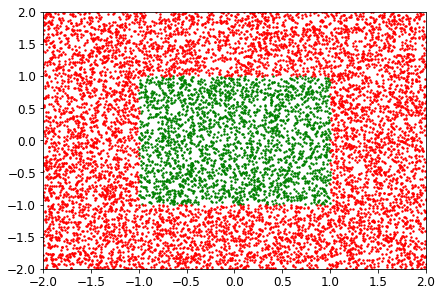

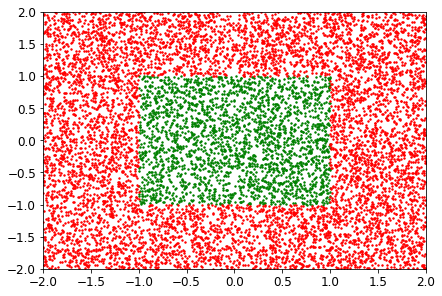

In [ ]:
X, f, Xextrap = makeData(N_f = 2500, N_df = 7500, showfig = True)
# Rather than use a train_test_split, I will just generate different data points again
# The seed has been commented out for this reason
Xtest, ftest, Xextrap_test = makeData(N_f = 2500, N_df = 7500, showfig = True)

In [ ]:
# If want touse train_test_split instead
#Dtrain, Dtest = train_test_split(np.c_[X,f], test_size = 0.5, random_state = 0)
#Dtrain_ex, Dtest_ex = train_test_split(Xextrap.numpy(), test_size = 0.5, random_state = 0)

#Dtrain_X = Dtrain[:, 0:2]
#Dtest_X = Dtest[:, 0:2]
#Dtrain_f = Dtrain[:,2]
#Dtest_f = Dtest[:,2]



#dataset_list_train = []
#dataset_list_train.append(tf.convert_to_tensor(Dtrain_X, dtype=tf.float32))
#dataset_list_train.append(tf.convert_to_tensor(Dtrain_f, dtype=tf.float32))
#dataset_list_train.append(tf.convert_to_tensor(Dtrain_ex, dtype=tf.float32))


In [ ]:
dataset_list = []
dataset_list.append(tf.convert_to_tensor(X, dtype=tf.float32))
dataset_list.append(tf.convert_to_tensor(f, dtype=tf.float32))
dataset_list.append(tf.convert_to_tensor(Xextrap, dtype=tf.float32))

In [ ]:
"""
Function to make a grid of points, useful if plotting a heat map
"""
def makeGrid(xstart = -2, xend = 2, ystart = -2, yend = 2, N = 101):
  x = np.linspace(xstart, xend, N)
  y = np.linspace(ystart, yend, N)

  # full coordinate arrays
  xx, yy = np.meshgrid(x, y)

  X = tf.convert_to_tensor(np.array([xx.flatten(), yy.flatten()]).T)

  return X

In [ ]:
Xgrid = makeGrid() # Can be both extrapolation and interpolation

# PINNs Class

In [ ]:
# Physics-Informed NEURAL NETWORK CLASS
# SECTION 2.5 

class PhysicsInformedNN(keras.models.Model):

	#
	# Custom loss for function value
	# 
	def loss_function_f(self, f, f_pred):
		sq_diff = tf.math.squared_difference(f, f_pred)  
		loss_value = tf.math.reduce_sum(sq_diff)
		return loss_value			 
	# def loss_function_f
	
	#
	# Called from outside as a convenient way (albeit slightly risky)
	# to specify the mini-batch size
	#
	def set_batch_size(self, batch_size):
		self.batch_size = batch_size

	#
	# Create mini batches
	#
	@tf.function
	def create_mini_batches(self, dataset):
		# Batch size should by user using the 'set_batch_size' function
		batch_size = self.batch_size

		X_f, f, X_df = dataset
		
		# Number of batches determined based on largest number of 
		# training samples (sizes of X_f and X_df may differ)
		m_f = X_f.shape[0]
		m_df = X_df.shape[0]
		m = np.max([m_f, m_df])
		num_batches = math.floor(m/batch_size)

		# Mini-batch sizes
		bs_f = math.floor(m_f/num_batches)
		bs_df = math.floor(m_df/num_batches)
		
		# Create mini-batches based on random selection
		perm_idx_f = np.random.permutation(m_f)
		perm_idx_df = np.random.permutation(m_df)
		batches = []

		for i in range(num_batches):
			idx0 = bs_f*i
			idx1 = bs_f*(i + 1)
			indices = perm_idx_f[idx0:idx1]
			X_f_b = tf.gather(X_f, indices, axis = 0)
			f_b = tf.gather(f, indices, axis = 0)
			
			idx0 = bs_df*i
			idx1 = bs_df*(i + 1)
			indices = perm_idx_df[idx0:idx1]
			X_df_b = tf.gather(X_df, indices, axis = 0)
			
			batch = (X_f_b, f_b, X_df_b)
			batches.append(batch)
		
		if (num_batches*bs_f < m_f) or (num_batches*bs_df < m_df):
			idx0 = bs_f*num_batches
			idx1 = m_f
			indices = perm_idx_f[idx0:idx1]
			X_f_b = tf.gather(X_f, indices, axis = 0)
			f_b = tf.gather(f, indices, axis = 0)

			idx0 = bs_df*num_batches
			idx1 = m_df
			indices = perm_idx_df[idx0:idx1]
			X_df_b = tf.gather(X_df, indices, axis = 0)
			
			batch = (X_f_b, f_b, X_df_b)
			batches.append(batch)
		
		return batches
	# def create_mini_batches	
	
	#
	# Redefine train_step used for optimizing the neural network parameters
	# This function implements one epoch (one pass over entire dataset)
	#
	@tf.function
	def train_step(self, dataset):
		
		# Retrieve size of entire dataset (X_f, f, X_df)
		m_f = dataset[0].shape[0]	# dataset[0] = X_f
		
		mini_batches = self.create_mini_batches(dataset)	
		
		# Keep track of total loss value for this epoch
		loss_value_f = 0.0
		loss_value_df = 0.0
		
		# Loop over all mini-batches
		for batch in mini_batches:
			
			L_f, L_df = self.process_one_batch(batch)
						
			# Increment total loss value by mini-batch-wise contribution
			loss_value_f += L_f
			loss_value_df += L_df

		# end for loop on mini batches
		
		# KB: This is the loss function including regularization
		loss_value = loss_value_f/m_f + self._r*loss_value_df

		# Update loss and return value
		return {'loss': loss_value,
          'reg': loss_value_df,
          'MSE': loss_value_f/m_f}
		#return loss_value
		
	# def train_step
	
	#
	# Compute loss function terms for one batch (just summation, no mean
	@tf.function
	def process_one_batch(self, batch):
		X_f, f, X_df = batch
		
		# Compute regularization term
		with tf.GradientTape(persistent=False) as tape:
			
			# Forward run and compute base loss function
			f_pred = self.call(X_f)
			Lf = self.loss_function_f(f, f_pred)

			# Regularization
			with tf.GradientTape(persistent=True) as tape_reg:
				tape_reg.watch(X_df)
				# KB: Below is the gradient computation
				# Hack to enable gradient computation w.r.t. columns x and y
				x, y = tf.unstack(X_df, axis=1)
				X_df = tf.stack([x,y], axis=1)
				df_pred = self.call(X_df)
				dfdx = tape_reg.gradient(df_pred, x)
				dfdy = tape_reg.gradient(df_pred, y)
				dfdxx = tape_reg.gradient(dfdx, x)
				dfdyy = tape_reg.gradient(dfdy, y)
				dfdxy = tape_reg.gradient(dfdx, y)
			
			# KB: THIS IS THE REGULARIZER
			Lreg = tf.math.reduce_variance(dfdxx) + \
				   tf.math.reduce_variance(dfdyy) + \
				   2*tf.math.reduce_variance(dfdxy)
			
			# Total loss function is a weighted sum
			r = self._r
			L = Lf + r*Lreg
		
		# Compute gradient of total loss w.r.t. trainable variables
		trainable_vars = self.trainable_variables
		dLdtheta = tape.gradient(L, trainable_vars)
	
		# Update network parameters
		self.optimizer.apply_gradients(zip(dLdtheta, trainable_vars))

		return Lf, Lreg
		
	# def process_one_batch
	
	#
	# Custom optimize function
	#
	def optimize(self, 
				 dataset, 
				 num_its,
				 regularization_schedule):
		self.regularization_schedule = regularization_schedule
		loss_history = []
		for it in range(num_its):
			self._r = self.get_regularization_penalty_factor(it)
			loss = self.train_step(dataset)
			tf.print("Epoch: ", it, ". Loss: ", loss['loss'], "R: ", self._r, '. MSE: ', loss['MSE'], '. Reg: ', loss['reg']);
			loss_history.append(loss)
		history = tf.keras.callbacks.History()
		history.history = {"loss": loss_history}
		return history
	# def optimize

	def get_regularization_penalty_factor(self, it):
		it0 = self.regularization_schedule["e0"]
		r0 = self.regularization_schedule["r0"]
		it1 = self.regularization_schedule["e1"]
		r1 = self.regularization_schedule["r1"]
		if it < it0:
			return r0
		elif (it >= it0) and (it <= it1):
			return r0 + (r1 - r0)*(it - it0)/(it1 - it0)
		else:
			return r1;
	# def get_regularization_penalty_factor

# class PhysicsInformedNN



# Bayesian Neural Networks

In [ ]:
def create_bnn_PINN_model(x, y, x_df,
							   	  num_epochs,
							   	  learning_rate,
                    layer_widths,
                    activation = 'sigmoid',
							   	  verbose=0):
  
    # Prior (non-trainable) distribution					
    def prior_fn(kernel_size, bias_size, dtype = None):
      n = kernel_size + bias_size;
      prior = Sequential([
        tfpl.DistributionLambda(lambda t:
        tfd.MultivariateNormalDiag(loc = tf.zeros(n), 
                      scale_diag = tf.ones(n)))
      ])
      return prior
      # def prior_fn()

    def posterior_fn(kernel_size, bias_size, dtype = None):
      #print(kernel_size, bias_size)
      n = kernel_size + bias_size
      posterior = Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), 
                  dtype=dtype),
        tfpl.IndependentNormal(n)
      ])
      return posterior
      # def posterior_fn()
  
    inputs = tf.keras.Input(shape=2)
    #features = keras.layers.concatenate(list(inputs))
    #features = layers.BatchNormalization()(features)

    features = inputs


    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    # We want to make the layers uniform, so the same activation function
    for units in layer_widths:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior_fn,
            make_posterior_fn=posterior_fn,
            kl_weight=1 / x.shape[0],
            activation=activation,
            use_bias = True
        )(features)

    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1)(features)   # activation function here is None, which means linear, shouldn't this cause problems?
    model = PhysicsInformedNN(inputs=inputs, outputs=outputs)
    return model





## Creating a Bayesian physics-informed neural network and fitting it

In [ ]:
opt_step = LEARNING_RATE		# gradient descent step
opt_batch_size = BATCH_SIZE	# batch size (128 < batch_size < 512)
opt_num_its = NUM_EPOCHS		# number of iterations
regularization_schedule = {"e0": 0,			 # starting epoch for regularization
						   "r0": 0.5,		 # starting penalty factor
						   "e1": opt_num_its,# ending epoch for regularization
						   "r1": 0.5}		 # ending penalty factor


In [ ]:
# Creating the neural network
model = create_bnn_PINN_model(X,       # Interpolation Data points (x,y)
                         f,       # functional values f(x,y) evaluated at interpolation data points (x,y) 
                         Xextrap,  # (x,y) data points to be extrapolated on
                         num_epochs = opt_num_its,  # epoch number
                         learning_rate = opt_step,   # Learning rate
                         layer_widths = [5, 5])   # Hidden layers with number of neurons
model.summary()

Model: "physics_informed_nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_variational (DenseVar  (None, 5)                30        
 iational)                                                       
                                                                 
 dense_variational_1 (DenseV  (None, 5)                60        
 ariational)                                                     
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fitting the neural network

# Set the size of each mini-batch
model.set_batch_size(opt_batch_size)

# We will use the Adam optimizer method with a prescribed learning rate. Note that this 
# learning rate MUST be consistent with the call to create_bnn_model
optimizer = optimizers.Adam(learning_rate = opt_step)
model.compile(optimizer = optimizer)  #  Compile model
tic = time.time()
'''
dataset = tf.data.Dataset.from_tensors((X, f, Xextrap))

fit_process = model.fit(dataset, 
		  				epochs=opt_num_its, 
					    verbose=2)
'''
fit_process = model.optimize(dataset_list, 
							 opt_num_its,
							 regularization_schedule)
               
toc = time.time()
print("Training time: {:.2F} s\n".format(toc - tic))

Streaming output truncated to the last 5000 lines.
Epoch:  2 . Loss:  0.218928143 R:  0.5 . MSE:  0.202193305 . Reg:  0.0334696695
Epoch:  3 . Loss:  0.223830104 R:  0.5 . MSE:  0.217799947 . Reg:  0.0120603126
Epoch:  4 . Loss:  0.199792504 R:  0.5 . MSE:  0.194461524 . Reg:  0.0106619494
Epoch:  5 . Loss:  0.203469783 R:  0.5 . MSE:  0.195768088 . Reg:  0.0154034
Epoch:  6 . Loss:  0.201582298 R:  0.5 . MSE:  0.196778297 . Reg:  0.00960799
Epoch:  7 . Loss:  0.187584743 R:  0.5 . MSE:  0.18480581 . Reg:  0.00555787887
Epoch:  8 . Loss:  0.18814677 R:  0.5 . MSE:  0.185295299 . Reg:  0.00570293283
Epoch:  9 . Loss:  0.183770746 R:  0.5 . MSE:  0.181004807 . Reg:  0.00553189078
Epoch:  10 . Loss:  0.190152243 R:  0.5 . MSE:  0.187159494 . Reg:  0.00598548632
Epoch:  11 . Loss:  0.184884429 R:  0.5 . MSE:  0.1828655 . Reg:  0.004037851
Epoch:  12 . Loss:  0.181884021 R:  0.5 . MSE:  0.178569481 . Reg:  0.00662906747
Epoch:  13 . Loss:  0.181506813 R:  0.5 . MSE:  0.180163562 . Reg:  0.0

In [ ]:
MSE = [f['MSE'].numpy() for f in fit_process.history['loss']]
REG = [f['reg'].numpy() for f in fit_process.history['loss']]
loss = [f['loss'].numpy() for f in fit_process.history['loss']]

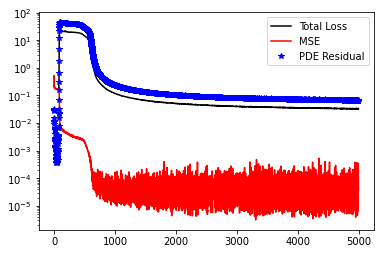

In [ ]:
plt.semilogy(loss, color = 'black', label = "Total Loss")
plt.semilogy(MSE, color = 'red', label = "MSE")
plt.semilogy(REG, 'b*', label = "PDE Residual")
plt.legend()
# Use semilog on y-axis 
# Plot the MSE and residual of PDE seperately

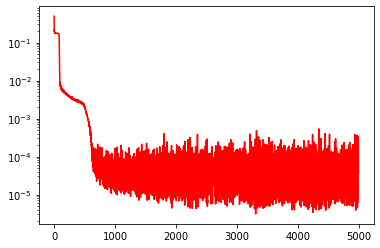

In [ ]:
plt.semilogy(MSE, color = 'red', label = "MSE")


Now that we have created a model and fit it to our interpolation data, we can see the prior and posterior distributions at each layer. If our model is becoming more confident, then the posterior variance should be small. Be sure to check that this is the case.

In [ ]:
layer_number = 1 # What layer do we want to see the distributions for

model_prior=model.layers[layer_number]._prior(np.array([[0]]))
print('Prior mean :     ', model_prior.mean().numpy())
print('Prior variance:  ', model_prior.variance().numpy())

model_posterior=model.layers[layer_number]._posterior(np.array([[0]]))
print('Posterior mean :     ', model_posterior.mean().numpy())
print('Posterior variance:  ', model_posterior.variance().numpy())

Prior mean :      [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Prior variance:   [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Posterior mean :      [ 1.1236537e-02  8.0269563e-01 -8.8415919e-03  1.4463783e-03
 -8.6761153e-01 -7.9906845e-01  1.4859807e-02  1.2292262e+00
  1.3659787e+00  2.8263782e-03 -2.9844768e+00 -2.5825417e+00
 -1.6112427e+00 -4.2693095e+00 -2.6258063e+00]
Posterior variance:   [5.2500320e-11 1.8093318e-13 5.5983202e-13 2.2092330e-13 3.6048831e-11
 3.8532283e-15 1.9579285e-14 4.6446955e-13 4.4853964e-11 1.0986420e-14
 2.4047486e-15 1.6920888e-10 9.2153534e-15 6.7180604e-13 2.9730592e-16]


## Quantifying Uncertainty using BPINNs

Now we will quantify the uncertainty in our prediction by passing our data through the neural network multiple times. Since our model is Bayesian, each time we will get a different result. We can aggregate the distribution of predictions $\hat{y}(x)$ into summary statistics to quantify uncertainty.

In [ ]:
N = 100   # Number of passes through the neural network

# Want to predict on the testing data, not training data
f_interp = np.zeros((len(Xtest), N))
f_extrap = np.zeros((len(Xextrap_test), N))
f_grid = np.zeros((len(Xgrid), N))

for i in range(N):
  f_interp[:,i] = model.predict(Xtest).flatten()  # Collect interpolation prediction for this pass through NN
  f_extrap[:,i] = model.predict(Xextrap_test).flatten() # Collect extrapolation prediction for this pass through NN
  f_grid[:,i] = model.predict(Xgrid).flatten()

f_interp_bpinn = pd.DataFrame(f_interp)
f_extrap_bpinn = pd.DataFrame(f_extrap)
f_grid_bpinn = pd.DataFrame(f_grid)

Now we will display the data in tabular format where each column is a different pass through the NN and the row is the data point

In [ ]:
f_interp_bpinn

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.914644,0.914593,0.914844,0.914665,0.914755,0.914731,0.914725,0.914697,0.914666,0.914711,...,0.914805,0.914773,0.914741,0.914800,0.914662,0.914699,0.914655,0.914781,0.914765,0.914825
1,1.286120,1.286202,1.286415,1.286252,1.286300,1.286289,1.286427,1.286294,1.286236,1.286215,...,1.286396,1.286306,1.286360,1.286338,1.286301,1.286257,1.286181,1.286419,1.286286,1.286388
2,1.446569,1.446657,1.446865,1.446704,1.446747,1.446740,1.446887,1.446750,1.446692,1.446663,...,1.446848,1.446753,1.446813,1.446788,1.446758,1.446713,1.446630,1.446874,1.446738,1.446838
3,0.508184,0.508164,0.508298,0.508224,0.508244,0.508251,0.508313,0.508250,0.508205,0.508209,...,0.508318,0.508251,0.508312,0.508290,0.508245,0.508244,0.508213,0.508300,0.508249,0.508303
4,1.850964,1.851040,1.851495,1.851132,1.851295,1.851220,1.851351,1.851201,1.851116,1.851182,...,1.851364,1.851333,1.851258,1.851311,1.851180,1.851126,1.851042,1.851420,1.851265,1.851409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.887609,0.887558,0.887507,0.887455,0.887526,0.887561,0.887573,0.887553,0.887555,0.887618,...,0.887505,0.887704,0.887520,0.887568,0.887501,0.887498,0.887489,0.887453,0.887538,0.887571
2496,0.877538,0.877612,0.877738,0.877596,0.877627,0.877474,0.877431,0.877609,0.877564,0.877634,...,0.877593,0.877512,0.877510,0.877508,0.877667,0.877589,0.877459,0.877618,0.877490,0.877426
2497,0.177518,0.177554,0.177639,0.177620,0.177622,0.177485,0.177433,0.177572,0.177554,0.177629,...,0.177574,0.177412,0.177476,0.177501,0.177695,0.177576,0.177415,0.177599,0.177492,0.177406
2498,0.288682,0.288704,0.288800,0.288792,0.288790,0.288642,0.288574,0.288726,0.288713,0.288795,...,0.288742,0.288547,0.288624,0.288650,0.288870,0.288736,0.288556,0.288761,0.288638,0.288541


In [ ]:
f_extrap_bpinn

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,6.843826,6.843936,6.843367,6.843671,6.843934,6.843943,6.843990,6.843729,6.843852,6.843636,...,6.843445,6.843569,6.843702,6.843629,6.843435,6.843469,6.843633,6.843780,6.843764,6.843529
1,2.866785,2.866821,2.866755,2.866825,2.866798,2.866857,2.866879,2.866804,2.866835,2.866792,...,2.866889,2.866906,2.866829,2.866767,2.866800,2.866735,2.866798,2.866865,2.866838,2.866820
2,2.327653,2.327678,2.327612,2.327673,2.327650,2.327727,2.327752,2.327681,2.327711,2.327643,...,2.327762,2.327754,2.327680,2.327659,2.327697,2.327606,2.327673,2.327747,2.327707,2.327696
3,2.665647,2.665674,2.665297,2.665454,2.665622,2.665709,2.665710,2.665633,2.665648,2.665460,...,2.665472,2.665435,2.665486,2.665528,2.665410,2.665492,2.665539,2.665622,2.665600,2.665481
4,2.120614,2.120669,2.120522,2.120582,2.120611,2.120688,2.120729,2.120642,2.120625,2.120562,...,2.120592,2.120609,2.120599,2.120542,2.120500,2.120577,2.120594,2.120597,2.120641,2.120613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,4.549757,4.550101,4.550020,4.549707,4.549956,4.549999,4.550003,4.549844,4.549700,4.550140,...,4.550079,4.550030,4.549652,4.550182,4.549798,4.550057,4.550055,4.550002,4.549704,4.550019
7496,2.341212,2.341345,2.341211,2.341285,2.341299,2.341314,2.341306,2.341158,2.341252,2.341332,...,2.341343,2.341272,2.341208,2.341356,2.341198,2.341264,2.341249,2.341201,2.341160,2.341218
7497,1.382261,1.382572,1.382438,1.382256,1.382524,1.382620,1.382510,1.382309,1.382250,1.382590,...,1.382536,1.382519,1.382159,1.382749,1.382293,1.382549,1.382499,1.382346,1.382267,1.382595
7498,4.224557,4.224523,4.224541,4.224594,4.224529,4.224605,4.224611,4.224473,4.224547,4.224628,...,4.224639,4.224531,4.224553,4.224576,4.224513,4.224616,4.224525,4.224504,4.224589,4.224524


In [ ]:
f_grid_bpinn

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,7.989182,7.989308,7.989347,7.989441,7.989102,7.989180,7.989537,7.989136,7.989227,7.989343,...,7.989322,7.989263,7.989353,7.989502,7.989408,7.989317,7.989353,7.989263,7.989435,7.989196
1,7.829823,7.829949,7.829984,7.830074,7.829746,7.829822,7.830173,7.829778,7.829867,7.829979,...,7.829959,7.829902,7.829993,7.830137,7.830046,7.829956,7.829992,7.829903,7.830069,7.829838
2,7.673448,7.673573,7.673605,7.673696,7.673374,7.673448,7.673794,7.673404,7.673491,7.673600,...,7.673582,7.673527,7.673615,7.673757,7.673666,7.673581,7.673612,7.673525,7.673689,7.673463
3,7.520135,7.520257,7.520288,7.520376,7.520061,7.520134,7.520473,7.520089,7.520174,7.520283,...,7.520266,7.520212,7.520298,7.520436,7.520347,7.520265,7.520294,7.520205,7.520370,7.520150
4,7.369943,7.370063,7.370093,7.370178,7.369873,7.369945,7.370276,7.369900,7.369981,7.370088,...,7.370073,7.370018,7.370103,7.370240,7.370154,7.370070,7.370098,7.370012,7.370173,7.369958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10196,7.409124,7.409225,7.409137,7.409797,7.409675,7.409304,7.409022,7.409006,7.409628,7.408895,...,7.409403,7.409086,7.409170,7.409497,7.409852,7.408835,7.409664,7.409621,7.409420,7.409807
10197,7.559144,7.559239,7.559158,7.559812,7.559696,7.559326,7.559034,7.559028,7.559638,7.558909,...,7.559420,7.559108,7.559190,7.559513,7.559863,7.558863,7.559681,7.559639,7.559436,7.559822
10198,7.712192,7.712282,7.712207,7.712858,7.712747,7.712376,7.712082,7.712079,7.712679,7.711954,...,7.712466,7.712157,7.712240,7.712560,7.712907,7.711918,7.712729,7.712681,7.712481,7.712864
10199,7.868205,7.868294,7.868222,7.868869,7.868764,7.868392,7.868093,7.868093,7.868686,7.867964,...,7.868480,7.868176,7.868257,7.868572,7.868914,7.867940,7.868742,7.868693,7.868494,7.868874


In [ ]:
# Interpolation summary data frame
InterpSummaryBPINN = pd.DataFrame()
InterpSummaryBPINN['x'] = Xtest[:,0]
InterpSummaryBPINN['y'] = Xtest[:,1]
InterpSummaryBPINN['mean'] = f_interp_bpinn.mean(axis = 1) 
InterpSummaryBPINN['std'] = f_interp_bpinn.std(axis = 1) 
InterpSummaryBPINN['true_mean'] = np.square(Xtest[:,0]) + np.square(Xtest[:,1])
InterpSummaryBPINN['diff_mean'] = f_interp_bpinn.mean(axis = 1) - InterpSummaryBPINN['true_mean']

# Extrapolation summary data frame
ExtrapSummaryBPINN = pd.DataFrame()
ExtrapSummaryBPINN['x'] = Xextrap_test[:,0]
ExtrapSummaryBPINN['y'] = Xextrap_test[:,1]
ExtrapSummaryBPINN['mean'] = f_extrap.mean(axis = 1) 
ExtrapSummaryBPINN['std'] = f_extrap.std(axis = 1) 
ExtrapSummaryBPINN['true_mean'] = np.square(Xextrap_test[:,0]) + np.square(Xextrap_test[:,1])
ExtrapSummaryBPINN['diff_mean'] = f_extrap.mean(axis = 1) - ExtrapSummaryBPINN['true_mean']


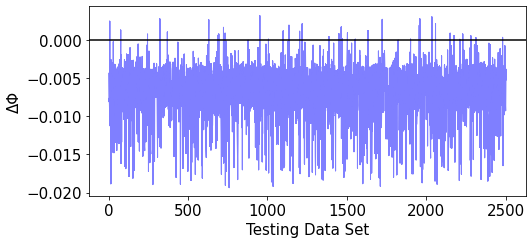

In [ ]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True


x = np.arange(0, 2500)
sds = f_interp_bpinn.std(axis = 1)
y = InterpSummaryBPINN['mean'] - (np.square(Xtest[:,0]) + np.square(Xtest[:,1]))

# Define the confidence interval
ci = 1.96 * sds / np.sqrt(len(y))

#plt.plot(x, y, color='grey', lw=1, alpha = 0.9)
fig, ax = plt.subplots()
plt.fill_between(x, (y-ci), (y+ci), color='blue', alpha=0.5)
plt.axhline(y = 0, color = 'black')
plt.xlabel("Testing Data Set", fontsize = 15)
plt.ylabel('ΔΦ', fontsize = 15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.xlim([1,4])
#plt.ylim([-0.1,0.1])

fig.savefig('BPINNInterpolationCI.svg')


plt.show()

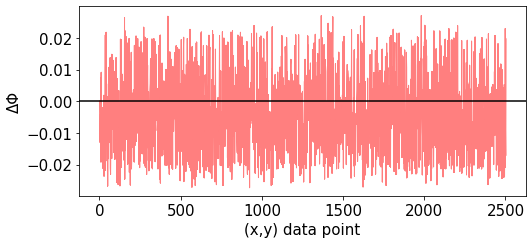

In [ ]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

x = np.arange(0, 7500)
sds = f_interp_bpinn.std(axis = 1)
y = ExtrapSummaryBPINN['mean'] - (np.square(Xextrap_test[:,0]) + np.square(Xextrap_test[:,1]))

# Define the confidence interval
ci = 1.96 * sds / np.sqrt(len(y))

#plt.plot(x, y, color='grey', lw=1, alpha = 0.5)
fig, ax = plt.subplots()

plt.fill_between(x, (y-ci), (y+ci), color='red', alpha=0.5)
plt.axhline(y = 0, color = 'black')
plt.xlabel("(x,y) data point", fontsize = 15)
plt.ylabel('ΔΦ', fontsize = 15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig.savefig('BPINNExtrapolationCI.svg')


plt.show()

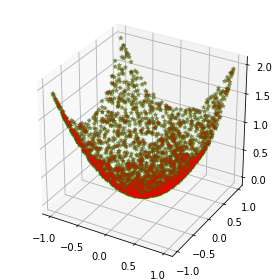

In [ ]:
fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(Xtest[:,0],Xtest[:,1], InterpSummaryBPINN['mean'], color = 'green', alpha = 0.4, marker = '*') # plot the point (2,3,4) on the figure
ax.scatter(Xtest[:,0],Xtest[:,1], np.square(Xtest[:,0]) + np.square(Xtest[:,1]), color = 'red', alpha = 0.2, marker = '.') # plot the point (2,3,4) on the figure

plt.show()

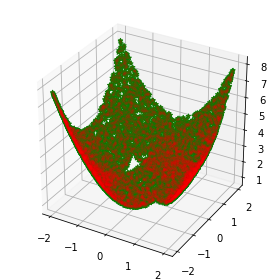

In [ ]:
fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(Xextrap_test[:,0],Xextrap_test[:,1], ExtrapSummaryBPINN['mean'], color = 'green', alpha = 1.0, marker = '*') # plot the point (2,3,4) on the figure
ax.scatter(Xextrap_test[:,0],Xextrap_test[:,1], np.square(Xextrap_test[:,0]) + np.square(Xextrap_test[:,1]), color = 'red', alpha = 0.1, marker = '.') # plot the point (2,3,4) on the figure

plt.show()

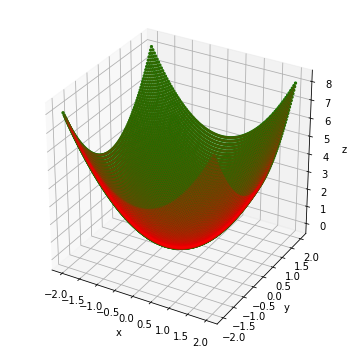

In [ ]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(Xgrid[:,0],Xgrid[:,1], model.predict(Xgrid), color = 'green', alpha = 1.0, marker = '.') # plot the point (2,3,4) on the figure
ax.scatter(Xgrid[:,0],Xgrid[:,1], np.square(Xgrid[:,0]) + np.square(Xgrid[:,1]), color = 'red', alpha = 0.1, marker = '.') # plot the point (2,3,4) on the figure
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

# Interpolation Heat Maps

In [ ]:
# Note that if inputting extrapolation data, it should be consistent with what was trained
def make_heat_map(x_start, y_start, x_end, y_end, N):

  x = np.linspace(x_start, x_end, N)
  y = np.linspace(y_start, y_end, N)

  # full coordinate arrays
  xx, yy = np.meshgrid(x, y)

  X = tf.convert_to_tensor(np.array([xx.flatten(), yy.flatten()]).T)

  f_heat = np.zeros((len(X), N))
  for i in range(N):
    f_heat[:,i] = model.predict(X).flatten()

  f_heat = pd.DataFrame(f_heat)

  fig, ax = plt.subplots()
  h = plt.contourf(x, y, f_heat.mean(axis = 1).values.reshape(N,N), cmap = 'plasma')
  plt.axis('scaled')
  plt.colorbar()
  plt.xlabel('x')
  plt.ylabel('y')
  fig.savefig('Mean_Heatmap_Parabola_LR_1e-3_BS_300_Epoch_5e3.svg')
  plt.show()

  # SD
  fig, ax = plt.subplots()
  h = plt.contourf(x, y, f_heat.std(axis = 1).values.reshape(N,N), cmap = 'plasma')
  # Below is the scatter plot for the training data to be overlayed on the SD heatmap
  # Alternatively, use X instead of Xtest/Xextrap_test to show the testing data
  #plt.scatter(Xtest[:,0], Xtest[:,1], color = 'black', alpha = 0.05)
  #plt.scatter(Xextrap_test[:,0], Xextrap_test[:,1], color = 'black', alpha = 0.05)
  plt.axis('scaled')
  plt.colorbar()
  plt.xlabel('x')
  plt.ylabel('y')
  fig.savefig('SD_Heatmap_Parabola_LR_1e-3_BS_300_Epoch_5e3.svg')
  plt.show()

  # Difference
  fig, ax = plt.subplots()
  placeholder = abs(f_heat.mean(axis = 1).values.reshape(-1,1) - (np.square(xx.reshape(-1,1)) + np.square(yy.reshape(-1,1))))

  h = plt.contourf(x, y, placeholder.reshape(N,N), cmap = 'plasma')
  plt.axis('scaled')
  plt.colorbar()
  plt.xlabel('x')
  plt.ylabel('y')
  fig.savefig('Difference_Heatmap_Parabola_LR_1e-3_BS_300_Epoch_5e3.svg')
  plt.show()



  fig = plt.figure()
  ax = plt.axes(projection='3d')
  ax.contour3D(x, y, f_heat.mean(axis = 1).values.reshape(N,N), 50, cmap='plasma')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z');



Low discrepancy sequence (fills space, sobol sequence) 

Spline sampling 

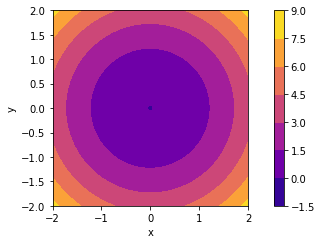

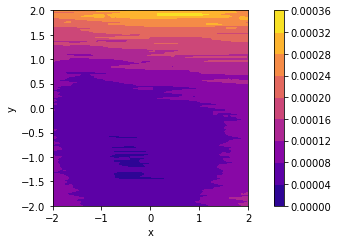

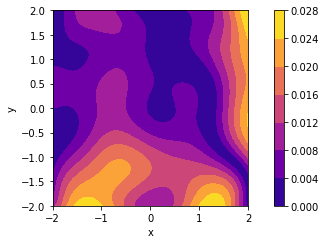

/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


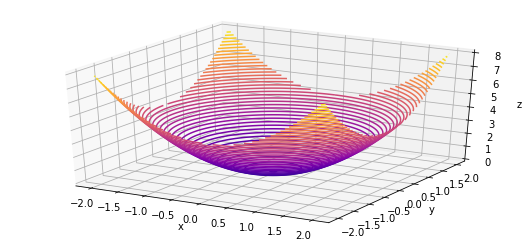

In [ ]:
make_heat_map(-2, -2, 2, 2, 101)

# Bayesian neural networks (not physics informed)

In [ ]:
'''
Train Bayesian neural network for nonlinear regression 
Output is classical (i.e., a point estimate and not a distribution)
'''
def create_bnn_noPINN(x, y,   # y = f(x,y)
							   	  num_epochs,
							   	  learning_rate,
                    layer_widths = [20,20],
							   	  verbose=1,
                    activation = 'sigmoid'):
  
  # Prior (non-trainable) distribution					
  def prior_fn(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size;
    prior = Sequential([
      tfpl.DistributionLambda(lambda t:
      tfd.MultivariateNormalDiag(loc = tf.zeros(n), 
                      scale_diag = tf.ones(n)))
    ])
    return prior

  def posterior_fn(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size
    posterior = Sequential([
      tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), 
                  dtype=dtype),
			tfpl.IndependentNormal(n)
		])
    return posterior

  inputs = tf.keras.Input(shape = 2)
  features = inputs


  # Create hidden layers with weight uncertainty using the DenseVariational layer.
  # We want to make the layers uniform, so the same activation function
  for units in layer_widths:
    features = tfp.layers.DenseVariational(
        units=units,
        make_prior_fn=prior_fn,
        make_posterior_fn=posterior_fn,
        kl_weight=1 / x.shape[0],
        activation=activation,
        use_bias = True
    )(features)

  # The output is deterministic: a single point estimate.
  outputs = layers.Dense(units=1)(features)   # activation function here is None, which means linear, shouldn't this cause problems?
  model = keras.models.Model(inputs=inputs, outputs=outputs)
 
  # swish, tanh and sigmoid, keep uniformity among layers (all same activation functions across layers)
  # don't use relu for PINNs
  # compare BNN and BPINNs with same architechtures
  # swish loss term of -3, -4 with PINNs
    
  model.summary()
  model.compile(loss = MeanSquaredError(), 
          optimizer = RMSprop(learning_rate = learning_rate))
	
  fit_history = model.fit(x = X, y = f, epochs = n_epochs, verbose = 1)


  return (model, fit_history)

In [ ]:
X, f, Xextrap = makeData()

In [ ]:
n_epochs = 5000; learning_rate = 0.01

BNN, fit_history = create_bnn_noPINN(X,  # (x,y)
                    f, 										# f(x,y)
                    num_epochs = n_epochs, 
                    learning_rate = learning_rate,
                    layer_widths = [5,5], 
                    verbose = 1,
                    activation = 'swish')


# x - (x.y), y - f(x,y)


Streaming output truncated to the last 5000 lines.
79/79 [==============================] - 0s 5ms/step - loss: 0.0276
Epoch 2502/5000
79/79 [==============================] - 0s 4ms/step - loss: 0.0275
Epoch 2503/5000
79/79 [==============================] - 0s 5ms/step - loss: 0.0279
Epoch 2504/5000
79/79 [==============================] - 0s 5ms/step - loss: 0.0279
Epoch 2505/5000
79/79 [==============================] - 0s 5ms/step - loss: 0.0279
Epoch 2506/5000
79/79 [==============================] - 0s 4ms/step - loss: 0.0265
Epoch 2507/5000
79/79 [==============================] - 0s 5ms/step - loss: 0.0283
Epoch 2508/5000
79/79 [==============================] - 0s 4ms/step - loss: 0.0269
Epoch 2509/5000
79/79 [==============================] - 0s 4ms/step - loss: 0.0276
Epoch 2510/5000
79/79 [==============================] - 0s 4ms/step - loss: 0.0276
Epoch 2511/5000
79/79 [==============================] - 0s 5ms/step - loss: 0.0277
Epoch 2512/5000
79/79 [==================

In [ ]:
BNN.summary()
dummy = np.array([[0]])
model_prior = BNN.layers[1]._prior(dummy)
model_posterior = BNN.layers[1]._posterior(dummy)
print('Prior mean :         ', model_prior.mean().numpy())
print('Prior variance:      ', model_prior.variance().numpy())
print('Posterior mean :     ', model_posterior.mean().numpy())
print('Posterior variance:  ', model_posterior.variance().numpy())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_variational_2 (DenseV  (None, 5)                30        
 ariational)                                                     
                                                                 
 dense_variational_3 (DenseV  (None, 5)                60        
 ariational)                                                     
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________
Prior mean :          [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

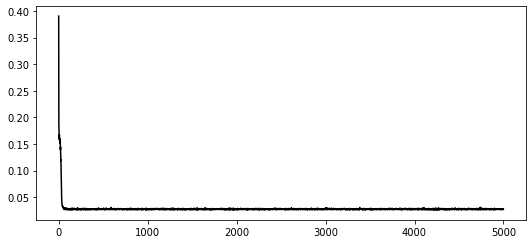

In [ ]:
plt.plot(fit_history.history['loss'], color = 'black', label = "Total Loss")



In [ ]:
N = 100   # Number of passes through the neural network

f_interp_bnn = np.zeros((len(Xtest), N))
f_extrap_bnn = np.zeros((len(Xextrap_test), N))

for i in range(N):
  f_interp_bnn[:,i] = BNN.predict(Xtest).flatten()  # Collect interpolation prediction for this pass through NN
  f_extrap_bnn[:,i] = BNN.predict(Xextrap_test).flatten() # Collect extrapolation prediction for this pass through NN

f_interp_bnn = pd.DataFrame(f_interp_bnn)
f_extrap_bnn = pd.DataFrame(f_extrap_bnn)

In [ ]:
# Interpolation summary data frame
InterpSummaryBNN = pd.DataFrame()
InterpSummaryBNN['x'] = Xtest[:,0]
InterpSummaryBNN['y'] = Xtest[:,1]
InterpSummaryBNN['mean'] = f_interp_bnn.mean(axis = 1) 
InterpSummaryBNN['std'] = f_interp_bnn.std(axis = 1) 
InterpSummaryBNN['true_mean'] = np.square(Xtest[:,0]) + np.square(Xtest[:,1])
InterpSummaryBNN['diff_mean'] = f_interp_bnn.mean(axis = 1) - InterpSummaryBNN['true_mean']

# Extrapolation summary data frame
ExtrapSummaryBNN = pd.DataFrame()
ExtrapSummaryBNN['x'] = Xextrap_test[:,0]
ExtrapSummaryBNN['y'] = Xextrap_test[:,1]
ExtrapSummaryBNN['mean'] = f_extrap_bnn.mean(axis = 1) 
ExtrapSummaryBNN['std'] = f_extrap_bnn.std(axis = 1) 
ExtrapSummaryBNN['true_mean'] = np.square(Xextrap_test[:,0]) + np.square(Xextrap_test[:,1])
ExtrapSummaryBNN['diff_mean'] = f_extrap_bnn.mean(axis = 1) - ExtrapSummaryBNN['true_mean']


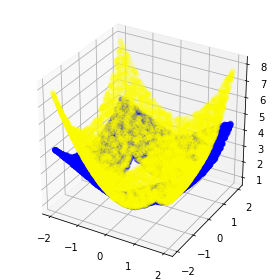

In [ ]:
fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(Xextrap_test[:,0],Xextrap_test[:,1], ExtrapSummaryBNN['mean'], color = 'blue') # plot the point (2,3,4) on the figure
ax.scatter(Xextrap_test[:,0],Xextrap_test[:,1], np.square(Xextrap_test[:,0]) + np.square(Xextrap_test[:,1]), color = 'yellow', alpha = 0.2) # plot the point (2,3,4) on the figure
plt.show()

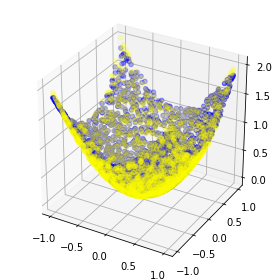

In [ ]:
fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(Xtest[:,0],Xtest[:,1], InterpSummaryBNN['mean'], color = 'blue') # plot the point (2,3,4) on the figure
ax.scatter(Xtest[:,0],Xtest[:,1], np.square(Xtest[:,0]) + np.square(Xtest[:,1]), color = 'yellow', alpha = 0.2) # plot the point (2,3,4) on the figure

plt.show()

In [ ]:
# Note that if inputting extrapolation data, it should be consistent with what was trained
def make_heat_mapBNN(x_start, y_start, x_end, y_end, N):

  x = np.linspace(x_start, x_end, N)
  y = np.linspace(y_start, y_end, N)

  # full coordinate arrays
  xx, yy = np.meshgrid(x, y)

  X = tf.convert_to_tensor(np.array([xx.flatten(), yy.flatten()]).T)

  f_heat = np.zeros((len(X), N))
  for i in range(N):
    f_heat[:,i] = BNN.predict(X).flatten()

  f_heat = pd.DataFrame(f_heat)

  fig, ax = plt.subplots()
  h = plt.contourf(x, y, f_heat.mean(axis = 1).values.reshape(N,N), cmap = 'plasma')
  plt.axis('scaled')
  plt.colorbar()
  plt.xlabel('x')
  plt.ylabel('y')
  fig.savefig('BNNMean_Heatmap_Parabola_LR_1e-3_BS_300_Epoch_5e3.svg')
  plt.show()

  # SD
  fig, ax = plt.subplots()
  h = plt.contourf(x, y, f_heat.std(axis = 1).values.reshape(N,N), cmap = 'plasma')
  # Below is the scatter plot for the training data to be overlayed on the SD heatmap
  # Alternatively, use X instead of Xtest/Xextrap_test to show the testing data
  #plt.scatter(Xtest[:,0], Xtest[:,1], color = 'black', alpha = 0.05)
  #plt.scatter(Xextrap_test[:,0], Xextrap_test[:,1], color = 'black', alpha = 0.05)
  plt.axis('scaled')
  plt.colorbar()
  plt.xlabel('x')
  plt.ylabel('y')
  fig.savefig('BNNSD_Heatmap_Parabola_LR_1e-3_BS_300_Epoch_5e3.svg')
  plt.show()

  # Difference
  fig, ax = plt.subplots()
  placeholder = abs(f_heat.mean(axis = 1).values.reshape(-1,1) - (np.square(xx.reshape(-1,1)) + np.square(yy.reshape(-1,1))))

  h = plt.contourf(x, y, placeholder.reshape(N,N), cmap = 'plasma')
  plt.axis('scaled')
  plt.colorbar()
  plt.xlabel('x')
  plt.ylabel('y')
  fig.savefig('BNNDifference_Heatmap_Parabola_LR_1e-3_BS_300_Epoch_5e3.svg')
  plt.show()



  fig = plt.figure()
  ax = plt.axes(projection='3d')
  ax.contour3D(x, y, f_heat.mean(axis = 1).values.reshape(N,N), 50, cmap='plasma')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z');



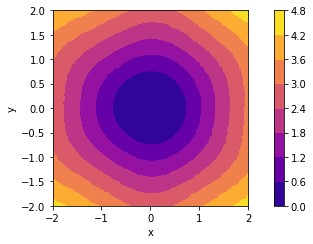

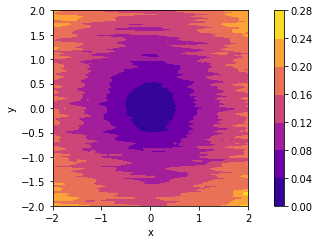

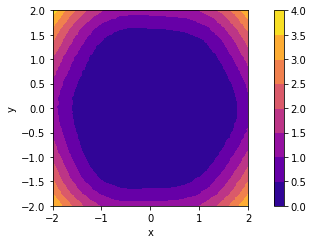

/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


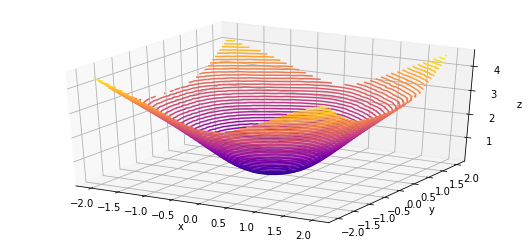

In [ ]:
make_heat_mapBNN(x_start=-2, y_start=-2, x_end=2, y_end=2, N=101)

In [ ]:
  x2 = np.linspace(-2, 2, 101)
  y2 = np.linspace(-2, 2, 101)

  # full coordinate arrays
  xxx, yyy = np.meshgrid(x2, y2)

  X2 = tf.convert_to_tensor(np.array([xxx.flatten(), yyy.flatten()]).T)


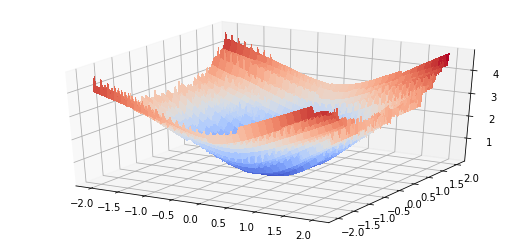

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xxx,yyy, BNN.predict(X2).reshape(101,101), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)



Not great at extrapolating! 


# Physics-Informed Neural Network (Not Bayesian)

In [ ]:
def create_pinn(layer_widths, activation):
	num_hidden_layers = len(layer_widths) - 2
	
	# Weight initializer
	initializer = keras.initializers.GlorotUniform()
	
	# Create input layer
	input_layer = keras.Input(layer_widths[0], 
							  name = 'input')

	# Create hidden layers
	layer = input_layer
	for i in range(num_hidden_layers):
		width = layer_widths[i + 1]
		name = 'h' + str(i)
		layer = keras.layers.Dense(width, 
							 	   activation=activation, name=name,
							 	   kernel_initializer=initializer)(layer)

	# Create output layer
	width = layer_widths[len(layer_widths) - 1]
	output_layer = keras.layers.Dense(width, 
									  name = 'output',
									  kernel_initializer = initializer)(layer)

	# Model
	model = PhysicsInformedNN(inputs=input_layer, outputs=output_layer)
	return model

In [ ]:
# Create TensorFlow dataset for passing to 'fit' function (below)
dataset = tf.data.Dataset.from_tensors((X, f, Xextrap))

dataset_list = []
dataset_list.append(tf.convert_to_tensor(X, dtype=tf.float32))
dataset_list.append(tf.convert_to_tensor(f, dtype=tf.float32))
dataset_list.append(tf.convert_to_tensor(Xextrap, dtype=tf.float32))

In [ ]:
# ------------------------------------------------------------------------------
# Create neural network (physics-inspired)
# ------------------------------------------------------------------------------
LAYERS = [2, 20, 20, 1]
model = create_pinn(LAYERS, 'sigmoid')
model.summary()

# ------------------------------------------------------------------------------
# Assess accuracy with non-optimized model
# ------------------------------------------------------------------------------
f_pred_0 = model.predict(X)
error_0 = np.sqrt(np.mean(np.square(f_pred_0 - f)))

# ------------------------------------------------------------------------------
# Model compilation / training (optimization)
# ------------------------------------------------------------------------------
opt_step = LEARNING_RATE			# gradient descent step
opt_batch_size = BATCH_SIZE	# batch size
opt_num_its = NUM_EPOCHS		# number of iterations
regularization_schedule = {"e0": 0,			 # starting epoch for regularization
						   "r0": 1.0,		 # starting penalty factor
						   "e1": opt_num_its,# ending epoch for regularization
						   "r1": 1.0}		 # ending penalty factor

model.set_batch_size(opt_batch_size)

optimizer = optimizers.Adam(learning_rate = opt_step)
model.compile(optimizer = optimizer)
tic = time.time()
'''
fit_process = model.fit(dataset, 
		  				epochs=opt_num_its, 
					    verbose=2)
'''
fit_process = model.optimize(dataset_list, 
							 opt_num_its,
							 regularization_schedule)
toc = time.time()
print("Training time: {:.2F} s\n".format(toc - tic))
#model.save("model.h5")


Streaming output truncated to the last 5000 lines.
Epoch:  2 . Loss:  0.182990536 R:  1.0 . MSE:  0.180980384 . Reg:  0.00201014965
Epoch:  3 . Loss:  0.183304891 R:  1.0 . MSE:  0.180365667 . Reg:  0.00293921772
Epoch:  4 . Loss:  0.185562804 R:  1.0 . MSE:  0.179551199 . Reg:  0.00601160713
Epoch:  5 . Loss:  0.203150615 R:  1.0 . MSE:  0.177163318 . Reg:  0.0259872973
Epoch:  6 . Loss:  0.355466962 R:  1.0 . MSE:  0.170943722 . Reg:  0.184523225
Epoch:  7 . Loss:  1.44261479 R:  1.0 . MSE:  0.156321719 . Reg:  1.28629303
Epoch:  8 . Loss:  6.4300456 R:  1.0 . MSE:  0.13184084 . Reg:  6.2982049
Epoch:  9 . Loss:  16.4551945 R:  1.0 . MSE:  0.108636402 . Reg:  16.3465576
Epoch:  10 . Loss:  20.1745205 R:  1.0 . MSE:  0.0976725 . Reg:  20.0768471
Epoch:  11 . Loss:  18.9382877 R:  1.0 . MSE:  0.091351144 . Reg:  18.8469372
Epoch:  12 . Loss:  18.3843327 R:  1.0 . MSE:  0.0825235397 . Reg:  18.3018093
Epoch:  13 . Loss:  19.7604046 R:  1.0 . MSE:  0.0662716925 . Reg:  19.6941338
Epoch: 

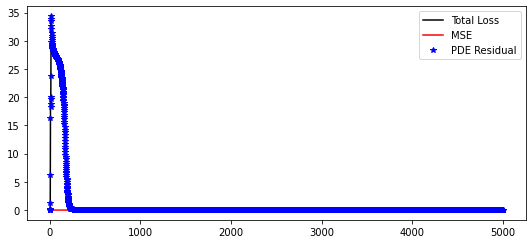

In [ ]:
MSE = [f['MSE'].numpy() for f in fit_process.history['loss']]
REG = [f['reg'].numpy() for f in fit_process.history['loss']]
loss = [f['loss'].numpy() for f in fit_process.history['loss']]


plt.plot(loss, color = 'black', label = "Total Loss")
plt.plot(MSE, color = 'red', label = "MSE")
plt.plot(REG, 'b*', label = "PDE Residual")
plt.legend()

# Plot the MSE and residual of PDE seperately

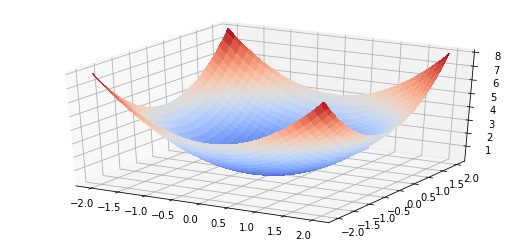

In [ ]:
x2 = np.linspace(-2, 2, 101)
y2 = np.linspace(-2, 2, 101)

# full coordinate arrays
xxx, yyy = np.meshgrid(x2, y2)

X2 = tf.convert_to_tensor(np.array([xxx.flatten(), yyy.flatten()]).T)


fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xxx,yyy, model.predict(X2).reshape(101,101), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)




For a normal PINN, it works amazingly, especially on extrapolation domain. 

In [ ]:
N = 100   # Number of passes through the neural network

f_interp_pinn = np.zeros((len(Xtest), N))
f_extrap_pinn = np.zeros((len(Xextrap_test), N))

for i in range(N):
  f_interp_pinn[:,i] = model.predict(Xtest).flatten()  # Collect interpolation prediction for this pass through NN
  f_extrap_pinn[:,i] = model.predict(Xextrap_test).flatten() # Collect extrapolation prediction for this pass through NN

f_interp_pinn = pd.DataFrame(f_interp_pinn)
f_extrap_pinn = pd.DataFrame(f_extrap_pinn)

In [ ]:
# Interpolation summary data frame
InterpSummaryPINN = pd.DataFrame()
InterpSummaryPINN['x'] = X[:,0]
InterpSummaryPINN['y'] = X[:,1]
InterpSummaryPINN['mean'] = f_interp_pinn.mean(axis = 1) 
InterpSummaryPINN['std'] = f_interp_pinn.std(axis = 1) 
InterpSummaryPINN['true_mean'] = np.square(X[:,0]) + np.square(X[:,1])
InterpSummaryPINN['diff_mean'] = f_interp_pinn.mean(axis = 1) - InterpSummaryBNN['true_mean']

# Extrapolation summary data frame
ExtrapSummaryPINN = pd.DataFrame()
ExtrapSummaryPINN['x'] = Xextrap[:,0]
ExtrapSummaryPINN['y'] = Xextrap[:,1]
ExtrapSummaryPINN['mean'] = f_extrap_pinn.mean(axis = 1) 
ExtrapSummaryPINN['std'] = f_extrap_pinn.std(axis = 1) 
ExtrapSummaryPINN['true_mean'] = np.square(Xextrap[:,0]) + np.square(Xextrap[:,1])
ExtrapSummaryPINN['diff_mean'] = f_extrap_pinn.mean(axis = 1) - ExtrapSummaryBNN['true_mean']


# Comparison between BNN and BPINN

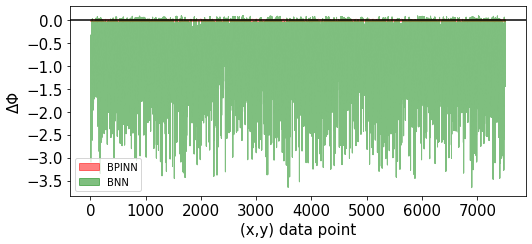

In [ ]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

x = np.arange(0, 7500)
sds = f_extrap_bpinn.std(axis = 1)
y = ExtrapSummaryBPINN['diff_mean']
y2 = ExtrapSummaryBNN['diff_mean']

# Define the confidence interval
ci = 1.96 * sds / np.sqrt(len(y))
ci2 = f_extrap_bnn.std(axis = 1) * 1.96 / np.sqrt(len(y2))

#plt.plot(x, y, color='grey', lw=1, alpha = 0.5)
fig, ax = plt.subplots()

plt.fill_between(x, (y-ci), (y+ci), color='red', alpha=0.5, label = "BPINN")
plt.fill_between(x, (y2-ci2), (y2+ci2), color='green', alpha=0.5, label = "BNN")

plt.axhline(y = 0, color = 'black')
plt.xlabel("(x,y) data point", fontsize = 15)
plt.ylabel('ΔΦ', fontsize = 15)
plt.legend()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig.savefig('BPINNExtrapolationCIvsBNN_5000Epoch_1e-2LR_256BS.svg')

#plt.title("Extrapolation")
plt.show()

Try [-4,4] extrapolation region, see whether sigmoid continues to work

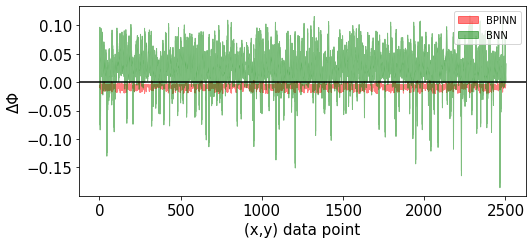

In [ ]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

x = np.arange(0, 2500)
sds = f_interp_bpinn.std(axis = 1)
y = InterpSummaryBPINN['diff_mean']
y2 = InterpSummaryBNN['diff_mean']


# Define the confidence interval
ci = 1.96 * sds / np.sqrt(len(y))
ci2 = f_interp_bnn.std(axis = 1) * 1.96 / np.sqrt(len(y2))

#plt.plot(x, y, color='grey', lw=1, alpha = 0.5)
fig, ax = plt.subplots()

plt.fill_between(x, (y-ci), (y+ci), color='red', alpha=0.5, label = "BPINN")
plt.fill_between(x, (y2-ci2), (y2+ci2), color='green', alpha=0.5, label = "BNN")

plt.axhline(y = 0, color = 'black')
plt.xlabel("(x,y) data point", fontsize = 15)
plt.ylabel('ΔΦ', fontsize = 15)
plt.legend()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig.savefig('BPINNInterpolationvsBNN_5000Epoch_1e-2LR_256BS.svg')
#plt.title('Interpolation')


plt.show()